In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.utils import to_categorical
import joblib
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
train_file_path = '/content/drive/My Drive/archive drug/drugsComTrain_raw.csv'
test_file_path = '/content/drive/My Drive/archive drug/drugsComTest_raw.csv'
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
df = pd.concat([train_data, test_data])

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text
# Apply preprocessing to the review column
df['review'] = df['review'].apply(lambda x: preprocess_text(str(x)))

In [ ]:
# Convert rating to sentiment
def rating_to_sentiment(rating):
    if rating > 5:
        return 'positive'
    elif rating == 5:
        return 'neutral'
    else:
        return 'negative'

In [ ]:
df['sentiment'] = df['rating'].apply(rating_to_sentiment)

# Encode sentiment labels
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Count Vectorizer
count_vectorizer = CountVectorizer(max_features=10000)

# Combine TF-IDF and Count Vectorizer
combined_features = FeatureUnion([("tfidf", tfidf_vectorizer), ("count", count_vectorizer)])

# Fit and transform training data
X_train_features = combined_features.fit_transform(X_train)
X_test_features = combined_features.transform(X_test)

# Tokenize the text for CNN input
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)


In [ ]:
vocab_size = 10000
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=256, validation_data=(X_test_pad, y_test_cat))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 1012s 2s/step - accuracy: 0.7572 - loss: 0.6269 - val_accuracy: 0.8362 - val_loss: 0.4452
Epoch 2/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 1051s 2s/step - accuracy: 0.8707 - loss: 0.3705 - val_accuracy: 0.8737 - val_loss: 0.3619
Epoch 3/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 1048s 2s/step - accuracy: 0.9251 - loss: 0.2092 - val_accuracy: 0.8895 - val_loss: 0.3654
Epoch 4/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 1025s 1s/step - accuracy: 0.9599 - loss: 0.1165 - val_accuracy: 0.9066 - val_loss: 0.3640
Epoch 5/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 1004s 1s/step - accuracy: 0.9781 - loss: 0.0666 - val_accuracy: 0.9137 - val_loss: 0.4350


In [ ]:
def predict_sentiment(review):
    review = preprocess_text(review)
    review_seq = tokenizer.texts_to_sequences([review])
    review_pad = pad_sequences(review_seq, maxlen=max_len)
    prediction = model.predict(review_pad)
    sentiment_label = np.argmax(prediction)
    return le.inverse_transform([sentiment_label])[0]

In [ ]:
from sklearn.metrics import classification_report
# Predictions on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print precision, recall, and F1 score
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

1345/1345 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87     10722
     neutral       0.75      0.54      0.63      2218
    positive       0.93      0.96      0.95     30073

    accuracy                           0.91     43013
   macro avg       0.86      0.79      0.81     43013
weighted avg       0.91      0.91      0.91     43013



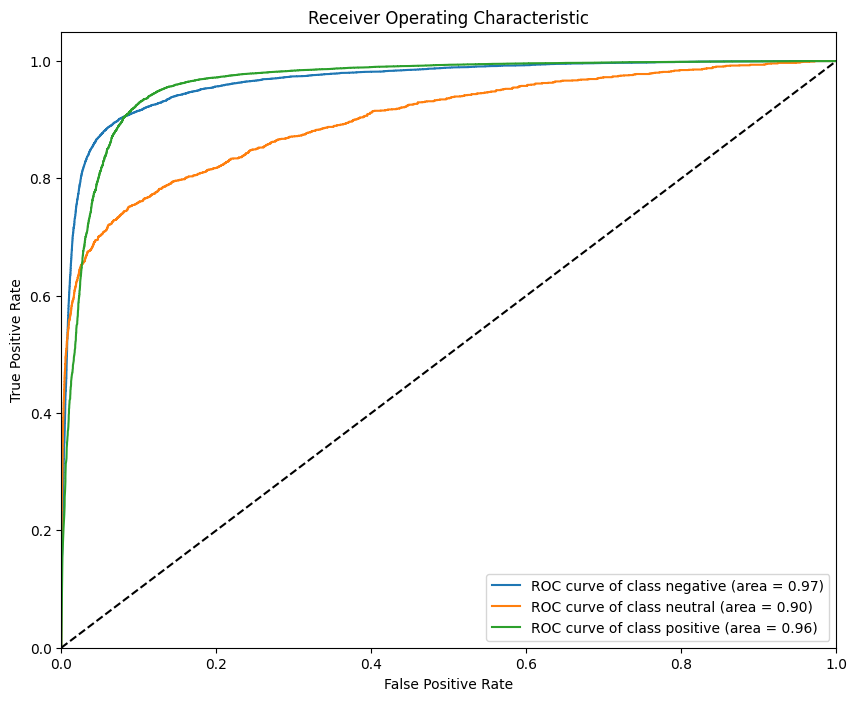

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
# Calculate AUC and ROC curve
# Convert y_test to one-hot encoding if it's not already
y_test_onehot = np.zeros((y_test.size, y_test.max() + 1))
y_test_onehot[np.arange(y_test.size), y_test] = 1

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Example usage
new_review = "This drug worked really well for me."
predicted_sentiment = predict_sentiment(new_review)
print(f'The predicted sentiment for the review is: {predicted_sentiment}')

1/1 [==============================] - 0s 95ms/step
The predicted sentiment for the review is: positive


In [ ]:
# Example usage
new_review = input()
predicted_sentiment = predict_sentiment(new_review)
print(f'The predicted sentiment for the review is: {predicted_sentiment}')

This didnt work for my condition
1/1 [==============================] - 0s 26ms/step
The predicted sentiment for the review is: negative


In [ ]:
# Example usage
new_review = input()
predicted_sentiment = predict_sentiment(new_review)
print(f'The predicted sentiment for the review is: {predicted_sentiment}')

Most effective drug
1/1 [==============================] - 0s 26ms/step
The predicted sentiment for the review is: positive


In [ ]:

import joblib
# Save the model
model.save('/content/drive/My Drive/drug/sentiment_model.h5')

# Save the tokenizer
with open('/content/drive/My Drive/drug/tokenizer.pkl', 'wb') as file:
    joblib.dump(tokenizer, file)

# Save the label encoder
with open('/content/drive/My Drive/drug/label_encoder.pkl', 'wb') as file:
    joblib.dump(le, file)

# Save the combined vectorizer
with open('/content/drive/My Drive/drug/combined_vectorizer.pkl', 'wb') as file:
    joblib.dump(combined_features, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
